In [76]:
%matplotlib inline
import skimage as sk
from skimage import transform
from skimage import util
from skimage import filters
from skimage import color
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from scipy import misc
import glob
import os
import sys
import cv2
from scipy.signal import correlate2d


In [362]:
def vflip(img: ndarray):
    return img[::-1, :]

def hflip(img: ndarray):
    return img[:, ::-1]

def rotate(img: ndarray, min_deg: float=-10., max_deg: float=10.):
    whr = np.where(img != 0)
    r, c = np.mean(whr[0]), np.mean(whr[1])
    angle = np.random.uniform(min_deg, max_deg)
    return sk.transform.rotate(img, angle, center=(r, c))

def sp_noise(img: ndarray):
    return sk.util.random_noise(img, mode='s&p')

def gauss_noise(img: ndarray):
    return sk.util.random_noise(img, mode='localvar')

def gauss_filter(img: ndarray, min_sigma: float=0.1, max_sigma: float=3.):
    sigma = np.random.uniform(min_sigma, max_sigma)
    return sk.filters.gaussian(img, sigma)

def shift(img: ndarray, min_dx:float=0.5, max_dx:float=2.):
    dx = np.random.uniform(min_dx, max_dx, size=2)
    tform = sk.transform.AffineTransform(translation=dx)
    return sk.transform.warp(img, tform.inverse)

def scale(img: ndarray, min_s:float=0.75, max_s:float=1.1):
    h, w = img.shape
    h = (h + 1.) * 0.5
    w = (w + 1.) * 0.5
    s = np.random.uniform(min_s, max_s, size=2)
    mtx = np.array([[s[0],  0, (-s[0]*w)+w],
                    [0,  s[1], (-s[1]*h)+h],
                    [0,    0,          1]])
    tform = sk.transform.AffineTransform(mtx)
    return sk.transform.warp(img, tform.inverse)

def shear(img: ndarray, min_s:float=0.01, max_s:float=0.1):
    h, w = img.shape
    r = (h + 1.) * 0.5
    c = (w + 1.) * 0.5
    ctr = sk.transform.AffineTransform(translation=(-r, -c))
    rectr = sk.transform.AffineTransform(translation=(r, c))
    s = np.random.uniform(min_s, max_s, size=1)
    tform = sk.transform.AffineTransform(shear=s)
    tform = ctr + tform + rectr
    return sk.transform.warp(img, tform.inverse)
    

TRANSFORMS = {
#     'vflip': (vflip, None),
#     'hflip': (hflip, None),
    'rotate': (rotate, (-20., 20.)),
#     's&p': (sp_noise, None),
#     'noise': (gauss_noise, None),
#     'smooth': (gauss_filter, (0.25, 1.)),
    'shift': (shift, (-10., 10.)),
    'scale': (scale, (0.75, 1.1)),
    'shear': (shear, (0.01, 0.5)) 
}

def random_transform(img: ndarray, n: int=1, xform: dict=TRANSFORMS):
    keys = sorted(xform.keys())
    replace = (n > len(xform)) 
    ts = np.random.choice(np.arange(len(xform)), size=n, replace=replace)
    _img = img.copy()
    for ki in ts:
#         print(ki, keys[ki])
        k = keys[ki]
        f, p = xform[k]
        _img[:] = f(_img, p[0], p[1]) if not p is None else f(_img)
    
    return _img


In [363]:

d = 'Latin'
# d = 'Futurama'
# d = 'Braille'
# d = 'Korean'

# print(os.getcwd())
centered = bool(1)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 32
size = 64
# size = 105
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)
small = None

for i0, c0 in enumerate(classes[1:]):
    print(c0)
    files0 = sorted(glob.glob(os.path.join(path, c0, '*.png')))
    img = sk.color.rgb2gray(sk.io.imread(files0[0])) == 0
    small = sk.transform.resize(img, (size, size), order=5, anti_aliasing_sigma=0.1)
#     plt.figure()
#     plt.imshow(img)

#     plt.figure()
#     plt.imshow(small)
#     plt.show()

    break



14 20 280
character02


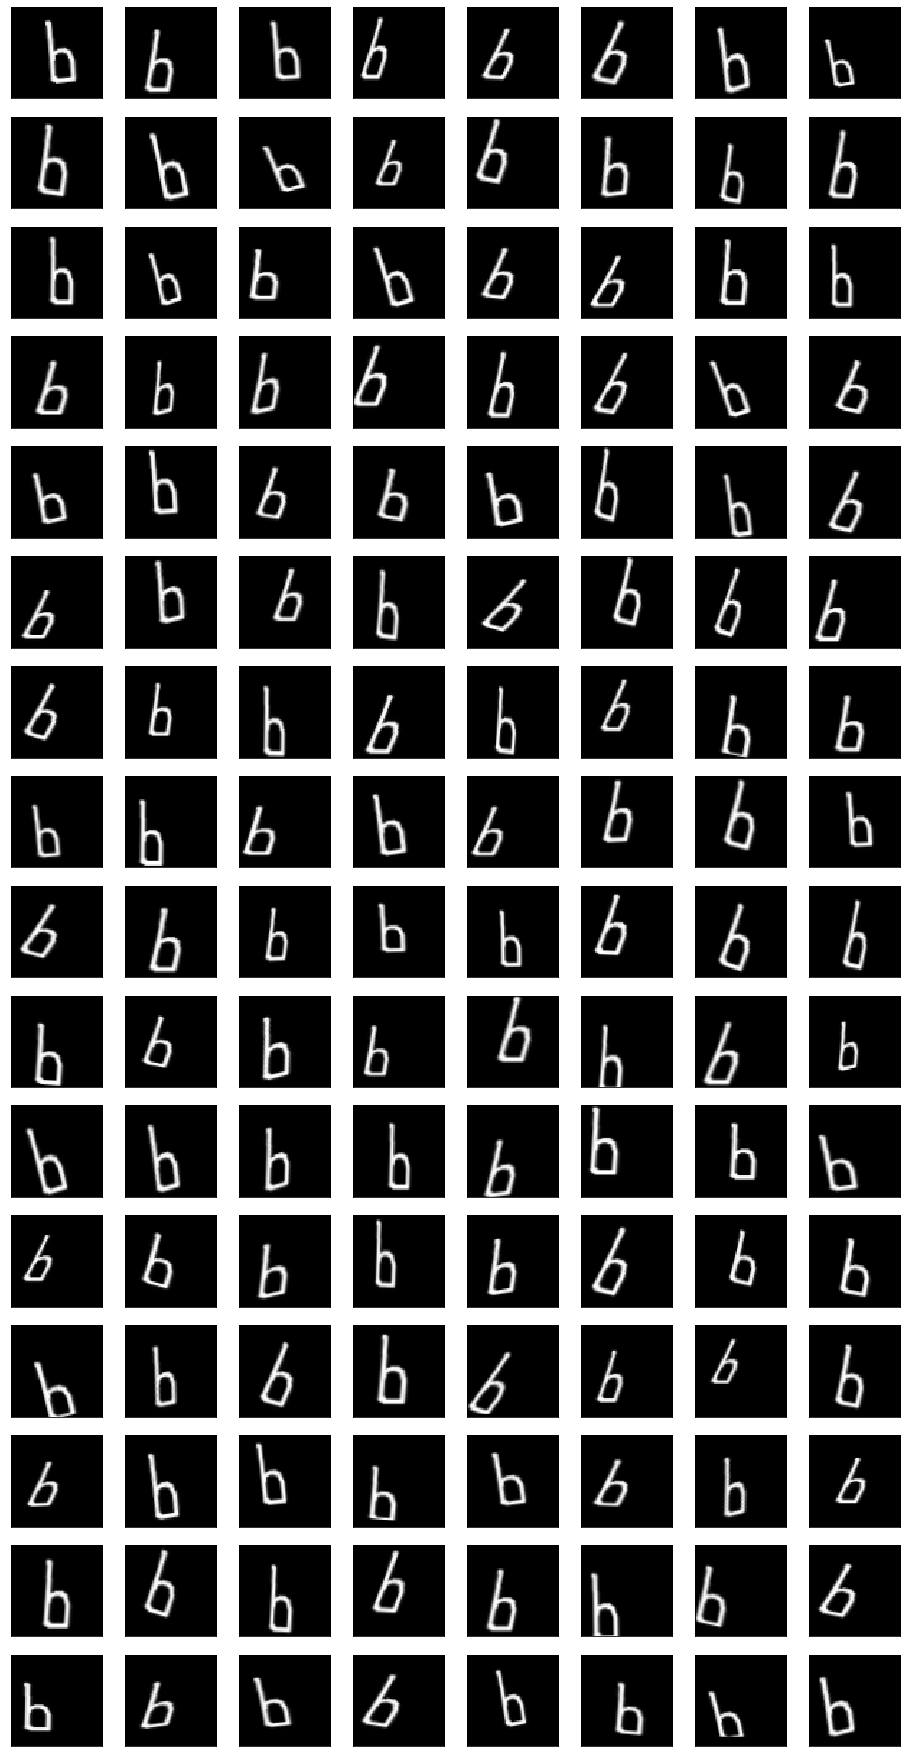

In [364]:
# print(sk.__version__)

# astro = sk.data.astronaut()
# small = sk.color.rgb2gray(sk.transform.resize(astro, (128, 128)))
total = 128
aug = [random_transform(small, 3) for _ in range(total)]
fw = 2.
cols = 8
rows = total // cols + int(total % cols > 0)
plt.figure(figsize=(fw*cols, fw*rows))
for i in range(total):
#     ax = plt.subplot(rows, cols, 1)
#     plt.imshow(small, cmap='gray')
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(aug[i], cmap='gray')
#     plt.imshow(small, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [365]:
from scipy.signal import correlate2d

to_del = {}
td = []
corrs = np.zeros((total, total))
for i0, img0 in enumerate(aug):
    for i1, img1 in enumerate(aug):
        if i1 < i0:
            continue
        m = np.sqrt((img0**2).sum() * (img1**2).sum())
        corrs[i0, i1] = correlate2d(img0, img1, mode='valid') * (1./m)
        if i0 != i1 and corrs[i0, i1] >= 0.8:
            l = to_del.get(i0, [])
            l.append(i1)
            to_del[i0] = l
            td.append(i1)




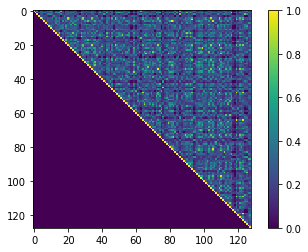

In [366]:
from pprint import pprint
from copy import copy

# pprint(to_del)
    
plt.figure()
im = plt.imshow(corrs)
plt.colorbar(im)
plt.show()

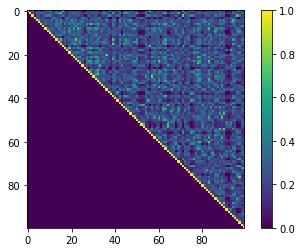

In [367]:
aug_clean = copy(aug)
for d in sorted(np.unique(td))[::-1]:
#     print(d)
    del aug_clean[d]

n = len(aug_clean)
corrs = np.zeros((n, n))
for i0, img0 in enumerate(aug_clean):
    for i1, img1 in enumerate(aug_clean):
        if i1 < i0:
            continue
        m = np.sqrt((img0**2).sum() * (img1**2).sum())
        corrs[i0, i1] = correlate2d(img0, img1, mode='valid') * (1./m)
        if i0 != i1 and corrs[i0, i1] >= 0.8:
            l = to_del.get(i0, [])
            l.append(i1)
            to_del[i0] = l
            td.append(i1)

plt.figure()
im = plt.imshow(corrs)
plt.colorbar(im)
plt.show()

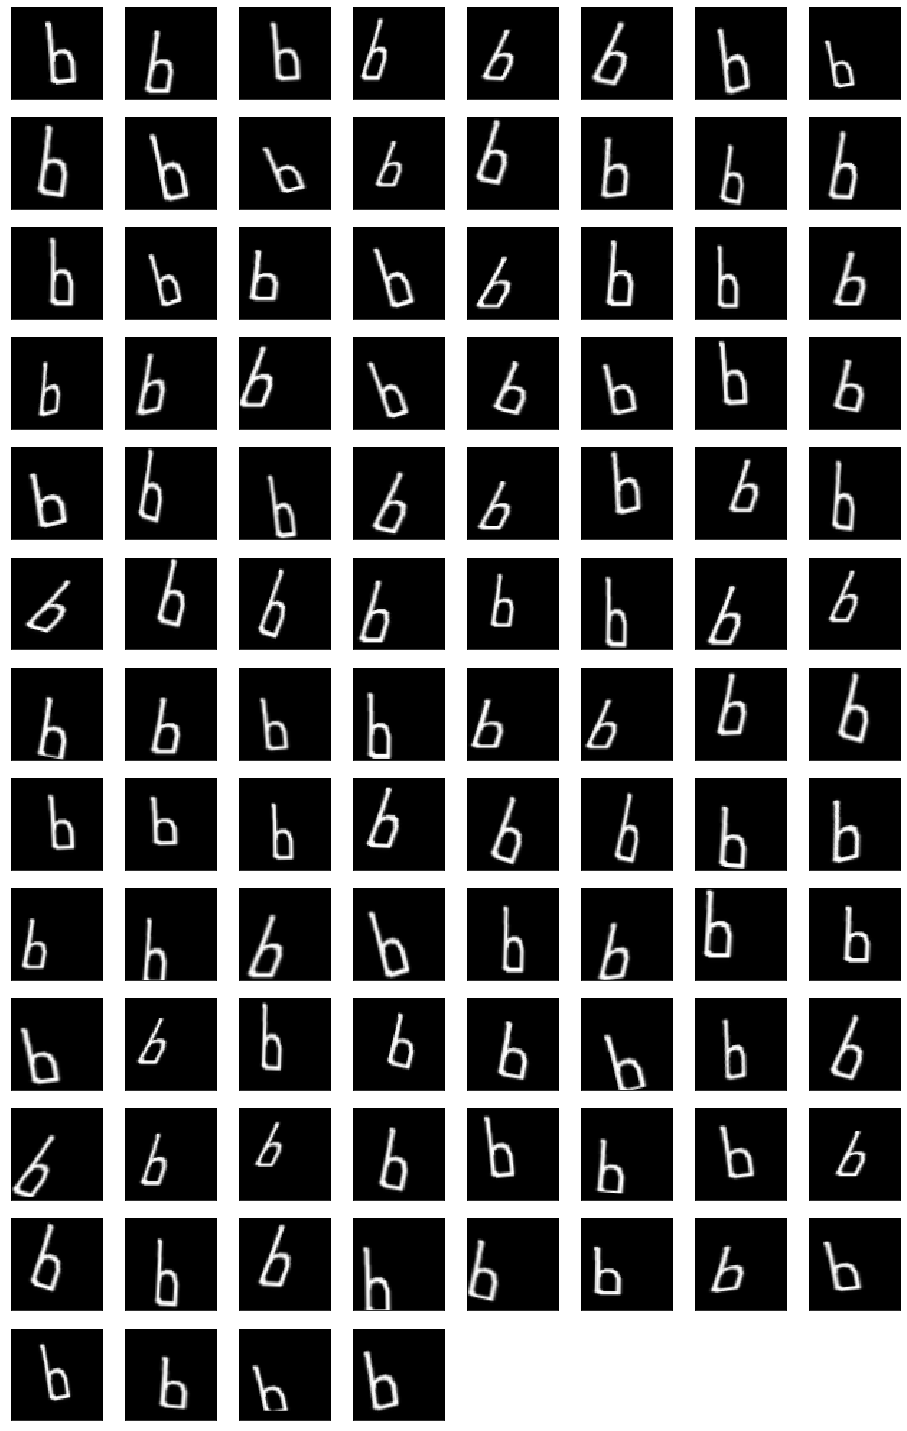

In [368]:
total = n
fw = 2.
cols = 8
rows = total // cols + int(total % cols > 0)
plt.figure(figsize=(fw*cols, fw*rows))
for i in range(total):
#     ax = plt.subplot(rows, cols, 1)
#     plt.imshow(small, cmap='gray')
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(aug_clean[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()